**Задание**

1. Выберите ряд из первого задания.
2. Постройте его модель ARIMA.
3. Оформите отчёт в Jupyter-ноутбук.

**Дополнительное задание***


Попробуйте спрогнозировать график классическим ML.

**Пункт 1 задания**

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
%matplotlib inline

In [2]:
# Возьмем для анализа следующий временной ряд
airlines_passengers = pd.read_csv("/content/international-airline-passengers.csv")

In [3]:
all_series = {"International airline passengers: monthly totals in thousands": airlines_passengers["Count"]}

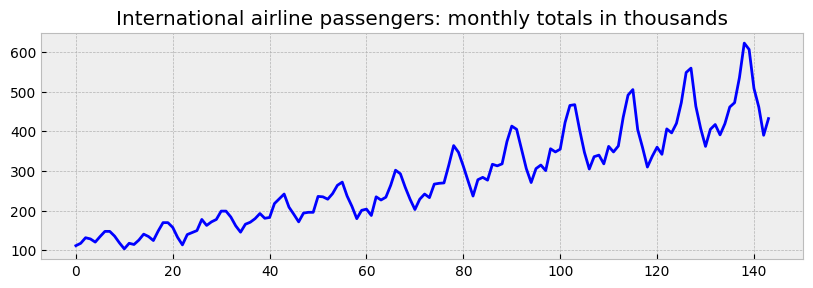

In [4]:
#Отобразим выбранный ВР

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Временной ряд "International airline passengers" нестационарный, поскольку:
1. Визуально не похож на шум
2. Имеет восходящий тренд
3. Имеет сезонность
4. Дисперсия монотонно возрастает
5. Из ДЗ №1 p-value по тесту Дики-Фуллера было > 0,05.

Подробный анализ ВР на предмет их стационарности проведен в ДЗ №1:

https://github.com/Pavel-Bonarev/HW_Time_series/blob/main/1_HW_Bonarev_Stat_time_series.ipynb

**Пункт 2 задания.**

Строим для ВР модель ARIMA

ARIMA (AutoRegressive Integrated Moving Average) - Авторегрессионное интегрированное скользящее среднее

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
#Преобразуем столбец 'Month' в DataTime

airlines_passengers['Month'] = pd.to_datetime(airlines_passengers['Month'])

In [8]:
airlines_passengers.head()

,Month,Count
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
airlines_passengers.set_index('Month', inplace=True)

In [10]:
airlines_passengers.head()

,Count
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


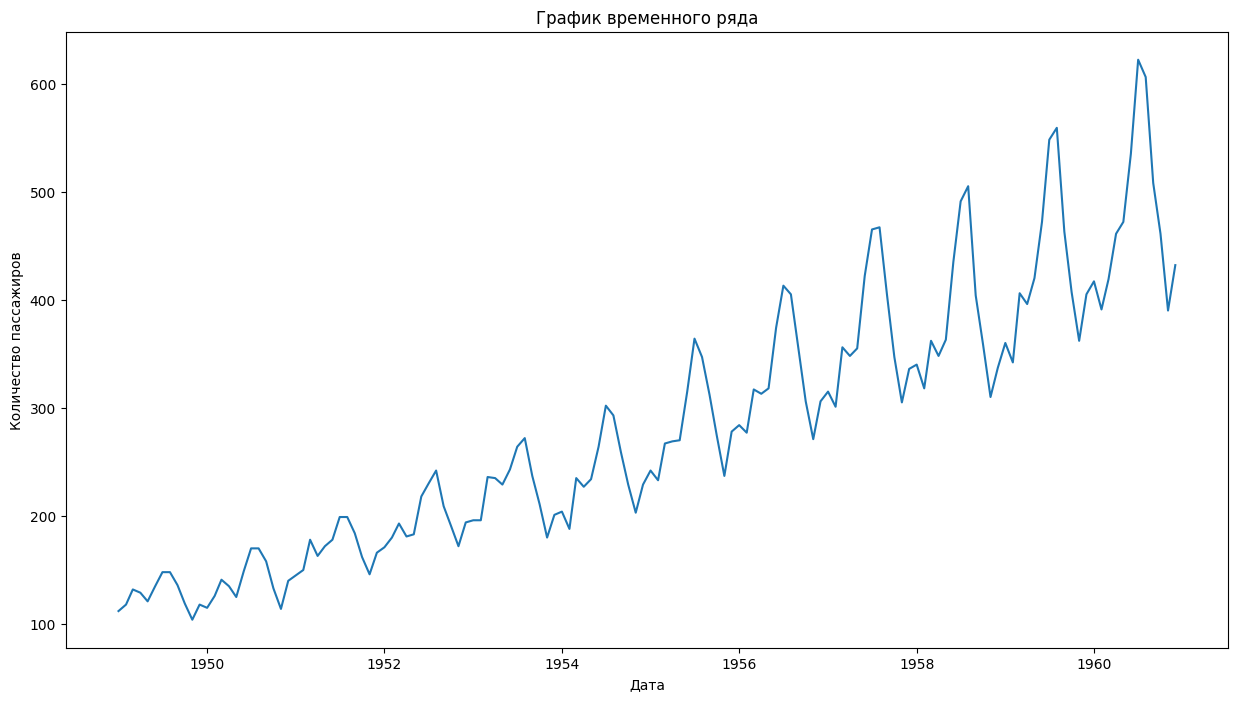

In [11]:
plt.figure(figsize=(15,8))
plt.plot(airlines_passengers['Count'])
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.show()

Модель ARIMA (p, d, q), где p, d и q — параметры модели:

- p — порядок авторегрессии, который описывает количество предыдущих наблюдений, принимаемых во внимание в модели.
- d — порядок интегрирования, который указывает, сколько раз нужно взять разность временного ряда для достижения стационарности.
- q — порядок скользящего среднего, который связан с количеством предыдущих ошибок, используемых в модели.

Сезонная модель ARIMA или SARIMA (Seasonal Autoregressive Integrated Moving Average) — это расширение модели ARIMA, добавляющее в нее понятие сезонности.

Для настройки параметров ARIMA используем метод «поиск по сетке» (grid search). Суть метода заключается в том, что он проходит через все возможные комбинации параметров из заранее определенной сетки значений и обучает модель на каждой из этих комбинаций.

После обучения модели на каждой из комбинаций выбирается модель с лучшими показателями.

In [12]:
#Для определения параметров модели определим функцию search_optimal_sarima.

def search_optimal_sarima(time_series, seasonal_cycle):

    #За создание диапазона параметров отвечают следующие три строчки кода:
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
    #p,d,q являются диапазонами от 0 до 2 (для относительно быстрого поиска),
    #Функция itertools.product() генерирует все возможные комбинации этих трех параметров.
    #Затем мы создаем дополнительные комбинации,
    #добавляя сезонный период к каждой из комбинаций pdq.
    #Это позволяет модели учитывать сезонные влияния на ряд динамики.


    #Цель — найти модель с наименьшим значением AIC (критерий информативности (Akaike Information Criterion))
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    '''
    Код ниже проводит итерацию по всевозможным комбинациям параметров
    и применяет функцию SARIMAX для построения сезонной модели ARIMA.
    Параметр 'order' устанавливает основные параметры (p, d, q),
    а 'seasonal_order' задает сезонные параметры модели (P, D, Q, S).
    '''
    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(airlines_passengers['Count'],
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

In [13]:
seasonal_cycle_length = 12
search_optimal_sarima(airlines_passengers, seasonal_cycle_length)

ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974989005


In [14]:
#Определяем модель SARIMAX с найденными параметрами
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(airlines_passengers, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

In [15]:
#Обучаем модель
results = model.fit()

In [16]:
#Выведем сводку по модели
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Count   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.164
Date:                            Tue, 06 Aug 2024   AIC                           1020.327
Time:                                    07:51:08   BIC                           1031.828
Sample:                                01-01-1949   HQIC                          1025.001
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3441      0.073     -4.701      0.000      -0.487      -0.201
ar.S.L12      -0.9382      0.206   

Из данной сводки важно обращать внимание на:
1. Коэффициенты (они должны быть статистически значимыми).

  P-значения коэффициентов (P>|z|) должны быть меньше 0.05 (*выполняется*).
2. Информационный критерий (AIC): меньшее значение AIC указывает на лучшую подгонку модели.
3. Ljung-Box (L1) (Q): это p-значение для Ljung-Box Q-статистики. Если значение больше 0.05, остатки случайны, что хорошо. (*не выполняется*)
4. Jarque-Bera (JB): это тест на нормальность остатков. Если Prob(JB) больше 0.05, остатки нормальны, что хорошо (*выполняется*).
5. Heteroskedasticity (H): это тест на гетероскедастичность остатков. Если Prob(H) (two-sided) больше 0.05, остатки гетероскедастичны, что хорошо (*не выполняется*).
  
  Гетероскедастичность — это ситуация, когда разброс ошибок прогнозов меняется в зависимости от того, в какой точке мы находимся (когда у нас имеется неоднородность в данных).

В идеальном случае наша модель должна иметь статистически значимые коэффициенты, небольшое значение AIC и нормально распределенные и не гетероскедастичные остатки. Соответствие этим критериям указывает на хорошую модель.

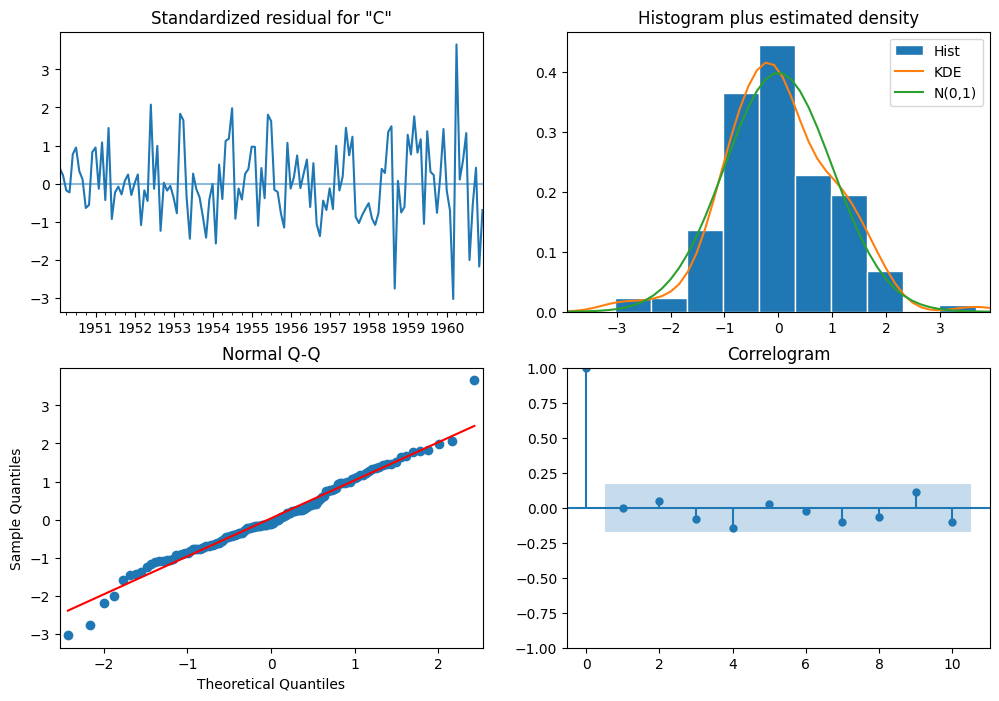

In [17]:
#Визуализируем диаграммы диагностики модели
results.plot_diagnostics(figsize=(12, 8))
plt.show()

Нами была отобрана модель, которая в целом соответствует требованиям, тем не менее, потенциал для совершенствования параметров сезонной модели ARIMA еще присутствует.

**Прогнозирование**

**Статический прогноз**

Сначала сгенерируем прогнозные значения с помощью модели, начиная с определенной даты и заканчивая конечной точкой наших данных. get_prediction возвращает объект прогнозирования, из которого мы можем извлечь прогнозные значения при помощи predicted_mean:

In [18]:
st_pred = results.get_prediction(start=pd.to_datetime('1958-01-01'), dynamic=False)
forecast_values = st_pred.predicted_mean

Теперь у нас есть прогнозные значения, которые мы можем сравнить с реальными данными временного ряда. Мы будем использовать среднеквадратичную ошибку (MSE) как нашу метрику оценки точности прогноза:

In [19]:
actual_values = airlines_passengers['1958-01-01':]['Count']
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)))

Среднеквадратичная ошибка прогноза составляет 232.79


Среднеквадратичная ошибка достаточно высокая.

Как отмечалось выше, следует расширить диапазон параметров и потратить больше времени на их нахождение. Вероятно, благодаря этому нам удастся улучшить качество модели.

Посмотрим на предсказания модели в сравнении с реальными данными

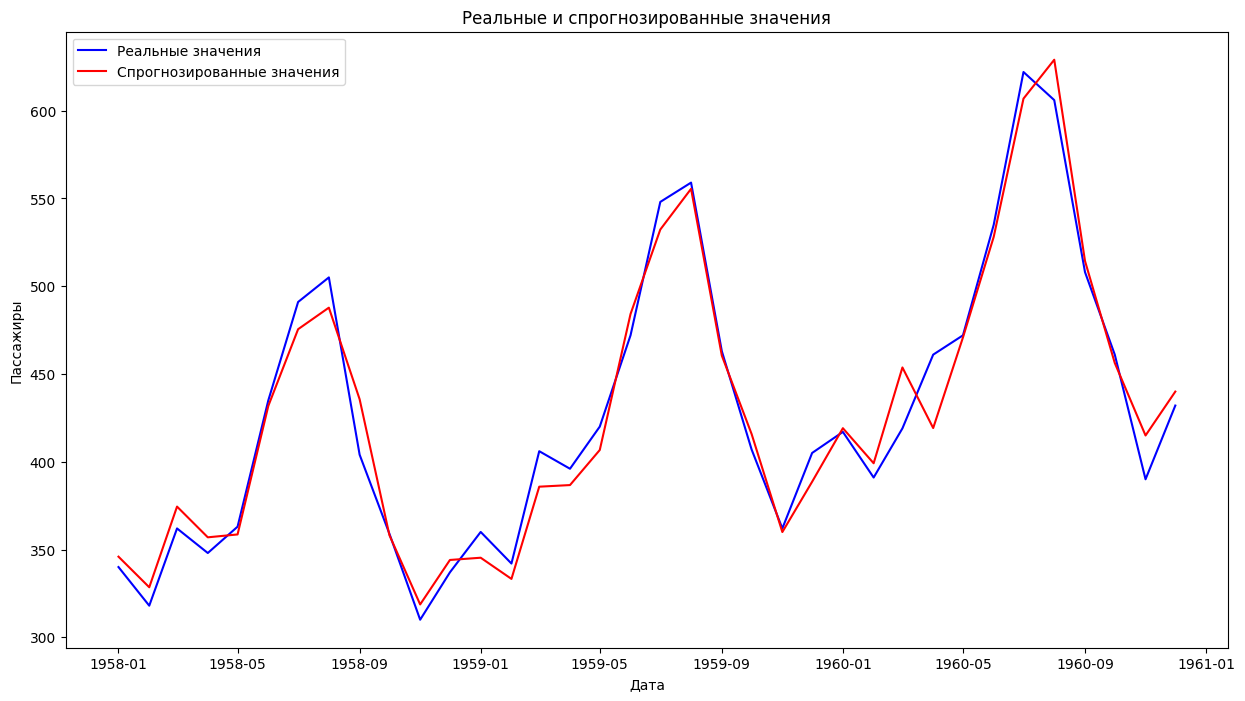

In [20]:
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

**Динамический прогноз**


В статическом прогнозе модель использует весь известный набор данных для прогнозирования каждого следующего значения.

Динамический прогноз начинает использовать самые свежие прогнозные значения для предсказания будущих значений, после определенной нами даты старта.

In [21]:
dyn_pred = results.get_prediction(start=pd.to_datetime('1958-01-01'), dynamic=True)
dynamic_forecast_values = dyn_pred.predicted_mean

In [22]:
mse_dynamic_forecast = ((dynamic_forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка динамического прогноза составляет {}'.format(round(mse_dynamic_forecast, 2)))

Среднеквадратичная ошибка динамического прогноза составляет 467.65


Как видно из mse, при использовании подхода для динамического прогноза данная метрика качества хуже, чем для статического, что также видно из графика ниже.

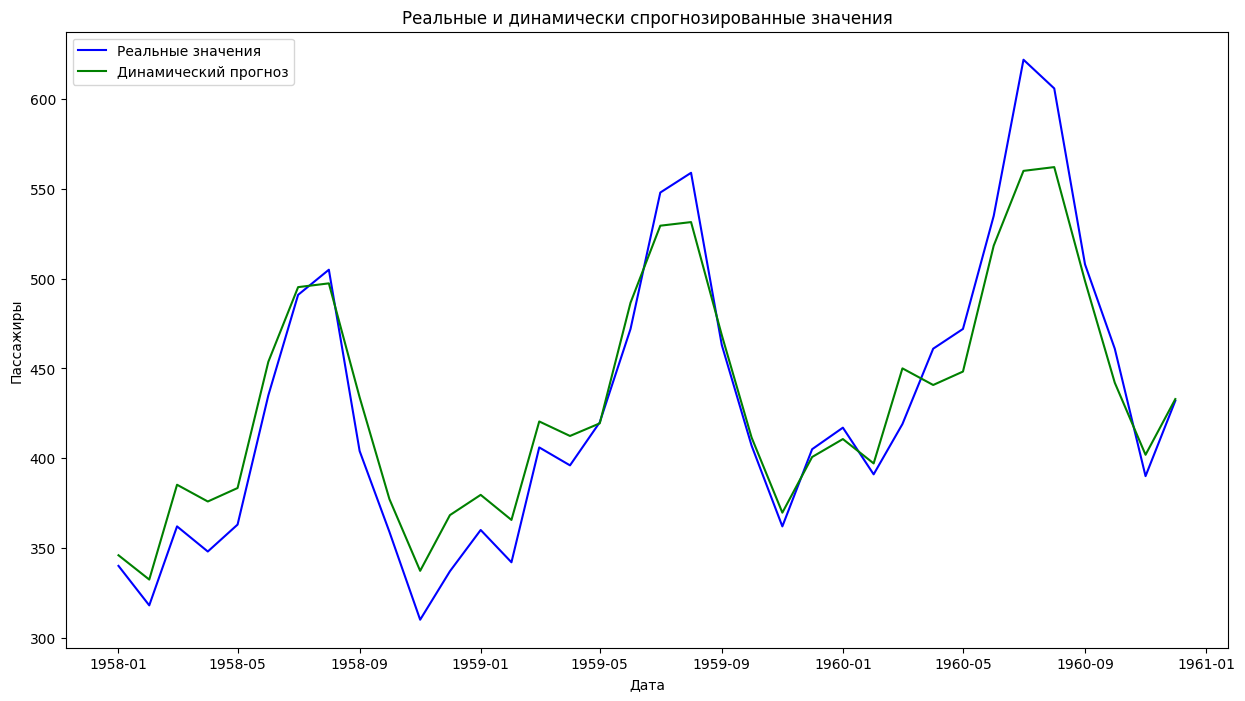

In [23]:
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(dynamic_forecast_values.index, dynamic_forecast_values, label='Динамический прогноз', color='green')

plt.title('Реальные и динамически спрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

In [24]:
#Выполним прогнозирование на определенное количество шагов вперед,
pred_future = results.get_forecast(steps=12)

Выведем средние прогнозируемые значения и доверительные интервалы:

In [25]:
print(f'Средние прогнозируемые значения:\n\n{pred_future.predicted_mean}')
print(f'\nДоверительные интервалы:\n\n{pred_future.conf_int()}')

Средние прогнозируемые значения:

1961-01-01    450.455292
1961-02-01    425.641168
1961-03-01    460.178526
1961-04-01    499.276272
1961-05-01    511.217958
1961-06-01    569.440803
1961-07-01    657.029774
1961-08-01    642.277325
1961-09-01    547.490219
1961-10-01    497.972624
1961-11-01    428.674581
1961-12-01    472.147872
Freq: MS, Name: predicted_mean, dtype: float64

Доверительные интервалы:

            lower Count  upper Count
1961-01-01   428.039473   472.871112
1961-02-01   398.835269   452.447068
1961-03-01   429.606586   490.750467
1961-04-01   465.353848   533.198696
1961-05-01   474.247454   548.188461
1961-06-01   529.655059   609.226547
1961-07-01   614.615240   699.444308
1961-08-01   597.387683   687.166967
1961-09-01   500.254985   594.725452
1961-10-01   448.502890   547.442357
1961-11-01   377.067005   480.282157
1961-12-01   418.487560   525.808185


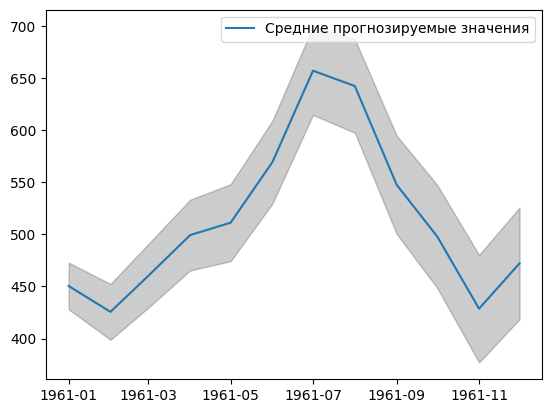

In [26]:
fig = plt.figure()
plt.plot(pred_future.predicted_mean, label='Средние прогнозируемые значения')
plt.fill_between(pred_future.conf_int().index,
                 pred_future.conf_int().iloc[:, 0],
                 pred_future.conf_int().iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

 Средние прогнозные значения показывают ожидаемое количество пассажиров каждый месяц в 1961 году, а заполненная область вокруг прогноза представляет собой доверительный интервал.

**Дополнительное задание***

In [27]:
# Обновим переменную для определения ВР
airlines_passengers = pd.read_csv("/content/international-airline-passengers.csv")

In [29]:
def prepareData(data, lag_start=1, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, lag_start=1, lag_end=20, test_size=0.3)


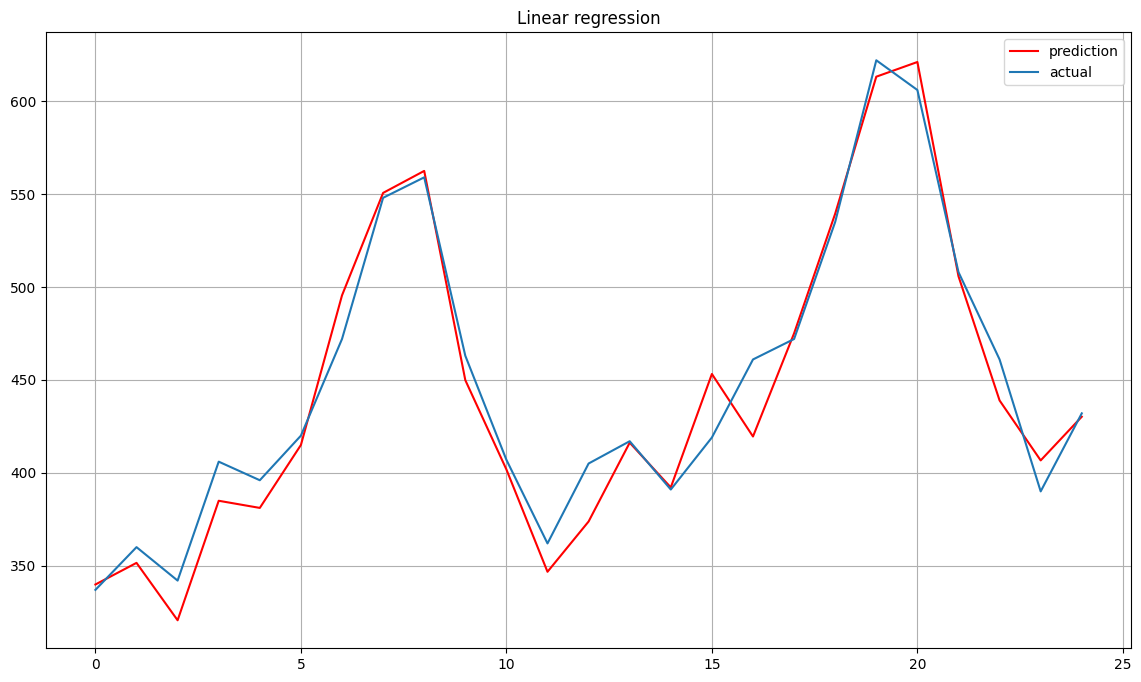

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [32]:
r2_score(y_pred=prediction, y_true=y_test.values)


0.9508893960507165

Показатель r2 достаточно высокий, что говорит о хорошем качестве модели.